# Clustering Crypto

In [40]:
# Initial imports
import requests
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import hvplot.pandas
import plotly.express as px
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

### Fetching Cryptocurrency Data

In [41]:
# Use the following endpoint to fetch json data
# url = "https://min-api.cryptocompare.com/data/all/coinlist"

In [42]:
# Create a DataFrame 
# HINT: You will need to use the 'Data' key from the json response, then transpose the DataFrame.

In [43]:
# Alternatively, use the provided csv file:
# file_path = Path("Resources/crypto_data.csv")
file_path = Path("Data/crypto_data.csv")
# Create a DataFrame
crypto_df = pd.read_csv(file_path, index_col=0)
crypto_df.head()

,CoinName,Algorithm,IsTrading,ProofType,TotalCoinsMined,TotalCoinSupply
42,42 Coin,Scrypt,True,PoW/PoS,4.199995e+01,42
365,365Coin,X11,True,PoW/PoS,NaN,2300000000
404,404Coin,Scrypt,True,PoW/PoS,1.055185e+09,532000000
611,SixEleven,SHA-256,True,PoW,NaN,611000
808,808,SHA-256,True,PoW/PoS,0.000000e+00,0


### Data Preprocessing

In [44]:
# Keep only necessary columns:
# 'CoinName','Algorithm','IsTrading','ProofType','TotalCoinsMined','TotalCoinSupply'
crypto_df = crypto_df[['CoinName',
           'Algorithm',
           'IsTrading',
           'ProofType',
           'TotalCoinsMined',
           'TotalCoinSupply']]
crypto_df.head()

,CoinName,Algorithm,IsTrading,ProofType,TotalCoinsMined,TotalCoinSupply
42,42 Coin,Scrypt,True,PoW/PoS,4.199995e+01,42
365,365Coin,X11,True,PoW/PoS,NaN,2300000000
404,404Coin,Scrypt,True,PoW/PoS,1.055185e+09,532000000
611,SixEleven,SHA-256,True,PoW,NaN,611000
808,808,SHA-256,True,PoW/PoS,0.000000e+00,0


In [45]:
# Keep only cryptocurrencies that are trading
crypto_df = crypto_df.loc[crypto_df['IsTrading'] == True]

In [46]:
# Keep only cryptocurrencies with a working algorithm
crypto_df = crypto_df.loc[crypto_df["Algorithm"] != "N/A"]

In [47]:
# Remove the "IsTrading" column
crypto_df = crypto_df.drop(columns = "IsTrading")

In [48]:
# Remove rows with at least 1 null value
crypto_df = crypto_df.dropna()
crypto_df.isnull().sum()

CoinName           0
Algorithm          0
ProofType          0
TotalCoinsMined    0
TotalCoinSupply    0
dtype: int64

In [49]:
# Remove rows with cryptocurrencies having no coins mined
crypto_df = crypto_df.loc[crypto_df["TotalCoinsMined"] != 0]

In [50]:
# Drop rows where there are 'N/A' text values
crypto_df = crypto_df.loc[crypto_df["TotalCoinSupply"] != 'N/A']
crypto_df = crypto_df.loc[crypto_df["ProofType"] != 'N/A']

In [51]:
# Store the 'CoinName'column in its own DataFrame prior to dropping it from crypto_df
coins_name = pd.DataFrame(crypto_df["CoinName"], index=crypto_df.index)

In [52]:
# Drop the 'CoinName' column since it's not going to be used on the clustering algorithm
crypto_df = crypto_df.drop(columns = "CoinName")
crypto_df.head(10)

,Algorithm,ProofType,TotalCoinsMined,TotalCoinSupply
42,Scrypt,PoW/PoS,4.199995e+01,42
404,Scrypt,PoW/PoS,1.055185e+09,532000000
1337,X13,PoW/PoS,2.927942e+10,314159265359
BTC,SHA-256,PoW,1.792718e+07,21000000
ETH,Ethash,PoW,1.076842e+08,0
LTC,Scrypt,PoW,6.303924e+07,84000000
DASH,X11,PoW/PoS,9.031294e+06,22000000
XMR,CryptoNight-V7,PoW,1.720114e+07,0
ETC,Ethash,PoW,1.133597e+08,210000000
ZEC,Equihash,PoW,7.383056e+06,21000000


In [53]:
# Create dummy variables for text features        
X = pd.get_dummies(crypto_df, columns=['Algorithm', 'ProofType'], drop_first=True)

In [54]:
# Standardize data
X = StandardScaler().fit_transform(X)

### Reducing Dimensions Using PCA

In [55]:
# Use PCA to reduce dimensions to 3 principal components
pca = PCA(n_components=3)
crypto_pca = pca.fit_transform(X)

In [56]:
# Create a DataFrame with the principal components data
pca_df = pd.DataFrame(data=crypto_pca, 
                      columns=["PC 1", "PC 2", "PC 3"],
                      index=crypto_df.index
                     )
pca_df.head()

,PC 1,PC 2,PC 3
42,-0.337050,0.992398,-0.602111
404,-0.320353,0.992587,-0.602591
1337,2.288725,1.599991,-0.684148
BTC,-0.146419,-1.330258,0.193797
ETH,-0.145979,-2.042856,0.423117


### Clustering Crytocurrencies Using K-Means

#### Find the Best Value for `k` Using the Elbow Curve

In [57]:
inertia = []
k = list(range(1, 11))

# Calculate the inertia for the range of k values
for i in k:
    km = KMeans(n_clusters=i, random_state=0)
    km.fit(pca_df)
    inertia.append(km.inertia_)


# Create the Elbow Curve using hvPlot
elbow_data = {"k": k, "inertia": inertia}
df_elbow = pd.DataFrame(elbow_data)
df_elbow.hvplot.line(x="k", y="inertia", xticks=k, title="Elbow Curve")

:Curve   [k]   (inertia)

Running K-Means with `k=<your best value for k here>`

In [59]:
# Initialize the K-Means model
model = KMeans(n_clusters=4, random_state=0)

# Fit the model
model.fit(pca_df)

# Predict clusters
predictions = model.predict(pca_df)

# Create a new DataFrame including predicted clusters and cryptocurrencies features
clustered_df = pd.DataFrame({
    "Algorithm": crypto_df["Algorithm"],
    "ProofType": crypto_df["ProofType"],
    "TotalCoinsMined": crypto_df["TotalCoinsMined"],
    "TotalCoinSupply": crypto_df["TotalCoinSupply"],
    "PC 1": pca_df["PC 1"],
    "PC 2": pca_df["PC 2"],
    "PC 3": pca_df["PC 3"],
    "CoinName": coins_name["CoinName"],
    "Class": model.labels_,
    },
    index=crypto_df.index
)
clustered_df.head()

,Algorithm,ProofType,TotalCoinsMined,TotalCoinSupply,PC 1,PC 2,PC 3,CoinName,Class
42,Scrypt,PoW/PoS,4.199995e+01,42,-0.337050,0.992398,-0.602111,42 Coin,0
404,Scrypt,PoW/PoS,1.055185e+09,532000000,-0.320353,0.992587,-0.602591,404Coin,0
1337,X13,PoW/PoS,2.927942e+10,314159265359,2.288725,1.599991,-0.684148,EliteCoin,0
BTC,SHA-256,PoW,1.792718e+07,21000000,-0.146419,-1.330258,0.193797,Bitcoin,1
ETH,Ethash,PoW,1.076842e+08,0,-0.145979,-2.042856,0.423117,Ethereum,1


### Visualizing Results

#### 3D-Scatter with Clusters

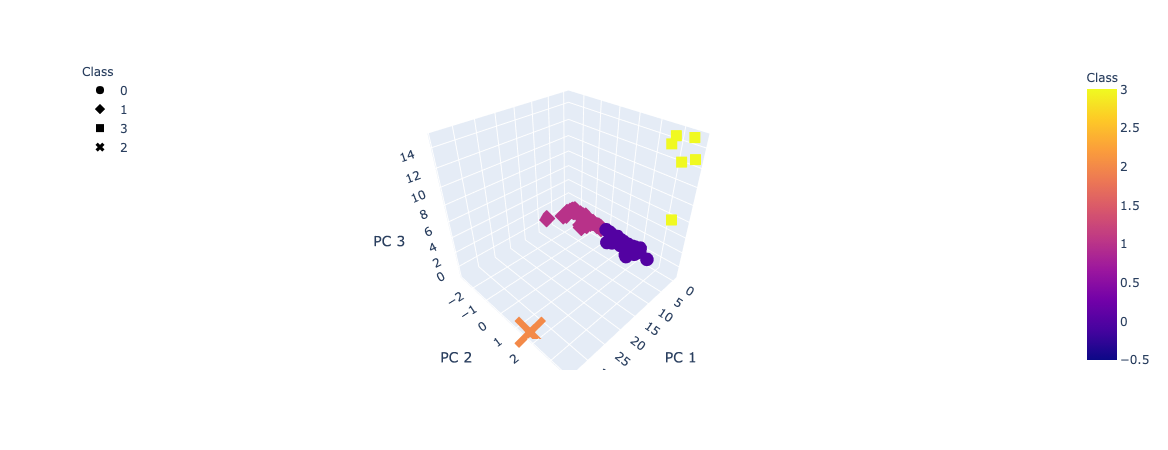

In [65]:
# Create a 3D-Scatter with the PCA data and the clusters
fig = px.scatter_3d(
    clustered_df,
    x="PC 1",
    y="PC 2",
    z="PC 3",
    color="Class",
    symbol="Class",
    width=800,
    hover_name="CoinName",
    hover_data=["Algorithm"]
)

fig.update_layout(legend=dict(x=0, y=1))
fig.show() 

#### Table of Tradable Cryptocurrencies

In [66]:
# Table with tradable cryptos
clustered_df.hvplot.table(columns=["CoinName", 
                             "Algorithm", 
                             "ProofType", 
                             "TotalCoinSupply", 
                             "TotalCoinsMined", 
                             "Class"]
                   )

:Table   [CoinName,Algorithm,ProofType,TotalCoinSupply,TotalCoinsMined,Class]

In [67]:
# Print the total number of tradable cryptocurrencies
print(f'The total number of tradable cryptocurrenices is: {len(clustered_df)}')

The total number of tradable cryptocurrenices is: 533


#### Scatter Plot with Tradable Cryptocurrencies

In [74]:
# Scale data to create the scatter plot
scaler = MinMaxScaler()

normalize_columns = ['TotalCoinsMined', 'TotalCoinSupply']
x = crypto_df[normalize_columns].values
x_scaled = scaler.fit_transform(x)

tradable_df = pd.DataFrame(x_scaled, columns=normalize_columns, index=crypto_df.index).reset_index()

In [75]:
# Plot the scatter with x="TotalCoinsMined" and y="TotalCoinSupply"
tradable_df.hvplot.scatter(x="TotalCoinsMined", 
                            y="TotalCoinSupply", 
                            hover_cols=["CoinName"])

:Scatter   [TotalCoinsMined]   (TotalCoinSupply)